In [6]:
import pandas as pd

# Load the dataset
file_path = '/content/MediaData.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,message:confidence,orig__golden,audience_gold,bias_gold,bioid,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,1.0,NaN,NaN,NaN,R000596,3.83E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,1.0,NaN,NaN,NaN,M000355,3.11E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,1.0,NaN,NaN,NaN,S001180,3.39E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,1.0,NaN,NaN,NaN,C000880,2.99E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,1.0,NaN,NaN,NaN,U000038,4.08E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...


Training set: 3000 samples \\
Validation set: 1000 samples \\
Test set: 1000 samples

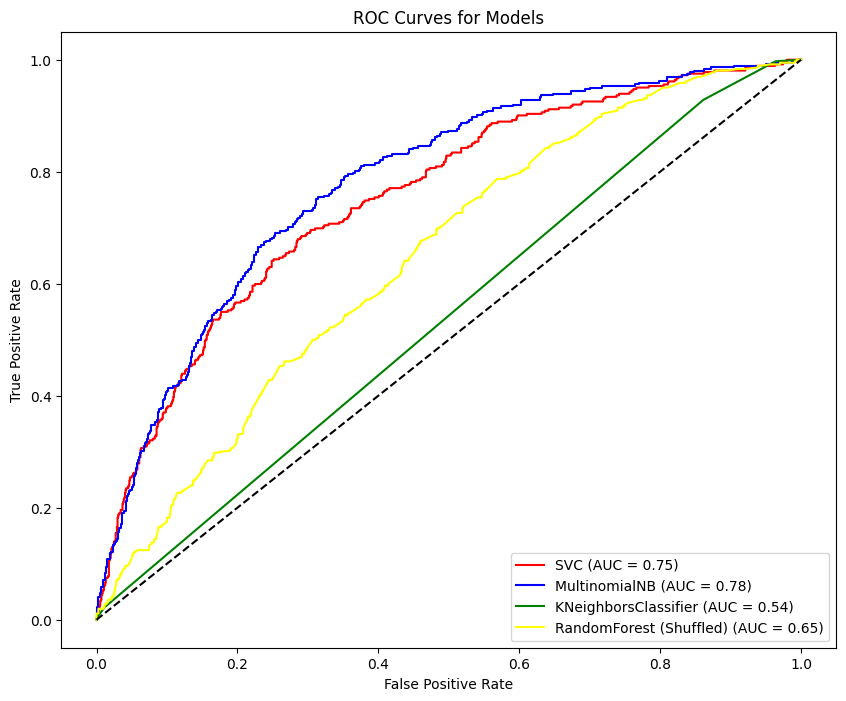

SVC - Accuracy: 0.78, Precision: 0.63, Recall: 0.25, F1-Score: 0.36, AUC: 0.75
MultinomialNB - Accuracy: 0.78, Precision: 0.60, Recall: 0.30, F1-Score: 0.40, AUC: 0.78
KNeighborsClassifier - Accuracy: 0.76, Precision: 0.38, Recall: 0.02, F1-Score: 0.04, AUC: 0.54
RandomForest (Shuffled) - Accuracy: 0.75, Precision: 0.44, Recall: 0.07, F1-Score: 0.12, AUC: 0.65


In [8]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Data preprocessing and cleaning
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

# Apply the cleaning function
data['cleaned_text'] = data['text'].apply(clean_text)

# Convert 'bias' column to binary format
label_encoder = LabelEncoder()
data['bias_binary'] = label_encoder.fit_transform(data['bias'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['bias_binary'], test_size=0.3, random_state=42)

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize models
svm_model = SVC(probability=True)
nb_model = MultinomialNB()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate models
models = [svm_model, nb_model, knn_model]
model_results = {}

for model in models:
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    model_auc = auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    model_results[type(model).__name__] = {
        'fpr': fpr, 'tpr': tpr, 'auc': model_auc,
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1
    }

# Simulate Online Random Forest training
X_shuffled, y_shuffled = shuffle(X_train_tfidf.toarray(), y_train, random_state=42)
n_chunks = 10
chunks_X_shuffled = np.array_split(X_shuffled, n_chunks)
chunks_y_shuffled = np.array_split(y_shuffled, n_chunks)

for X_chunk, y_chunk in zip(chunks_X_shuffled, chunks_y_shuffled):
    rf_model.fit(X_chunk, y_chunk)

y_pred_rf = rf_model.predict(X_test_tfidf)
y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
rf_auc = auc(fpr_rf, tpr_rf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

model_results['RandomForest (Shuffled)'] = {
    'fpr': fpr_rf, 'tpr': tpr_rf, 'auc': rf_auc,
    'accuracy': rf_accuracy, 'precision': rf_precision, 'recall': rf_recall, 'f1': rf_f1
}

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'yellow']
for (model_name, results), color in zip(model_results.items(), colors):
    plt.plot(results['fpr'], results['tpr'], color=color, label=f"{model_name} (AUC = {results['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend(loc="lower right")
plt.show()

# Print model performance metrics
for model_name, metrics in model_results.items():
    print(f"{model_name} - Accuracy: {metrics['accuracy']:.2f}, Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-Score: {metrics['f1']:.2f}, AUC: {metrics['auc']:.2f}")
